In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms.v2 import ToImage, ToDtype, Normalize, RandomAffine

from matplotlib import pyplot as plt
import numpy as np
import time
from datetime import datetime 

In [3]:
print(torch.cuda.is_available(), torch.cuda.get_device_name())

True NVIDIA GeForce RTX 4060


In [4]:
train_transforms = transforms.Compose([
    ToImage(), # to torch.Image uint8
    ToDtype(torch.float32, scale=True), # [0, 255] -> [0, 1] & uint8 -> float32
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # normalize after scale
    RandomAffine(
      degrees=10,
      translate=(0.15, 0.15),
      scale=(0.9, 1.1)
    )
])

test_transforms = transforms.Compose([
  ToImage(),
  ToDtype(torch.float32, scale=True),
  Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [5]:
trainD = datasets.CIFAR10(root="data", train=True, transform=train_transforms, download=True)
testD = datasets.CIFAR10(root="data", train=False, transform=test_transforms, download=True)

In [6]:
BATCH_SIZE = 256
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

trainDL = DataLoader(trainD, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
testDL = DataLoader(testD, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

In [7]:
class Cifar(nn.Module):
  def __init__(self):
    super().__init__()
    self.labels = {
      0: "airplane",  
      1: "automobile", 
      2: "bird",
      3: "cat",
      4: "deer",
      5: "dog",
      6: "frog",
      7: "horse",
      8: "ship",
      9: "truck"
    }
    self.model = nn.Sequential(
      nn.Conv2d(3, 64, 3, padding=1), # 32x32x64
      nn.ReLU(),

      nn.Conv2d(64, 128, 3), # 29x29x128
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 14x14x128

      nn.Conv2d(128, 256, 3, padding=1), # 14x14x256
      nn.ReLU(),

      nn.Conv2d(256, 216, 5), # 10x10x216 
      nn.ReLU(),
      nn.MaxPool2d(2, 2), # 5x5x216

      nn.Flatten(),
      nn.Linear(5*5*216, 512),
      nn.ReLU(),
      nn.Dropout(0.3),

      nn.Linear(512, 10)
    )

  def forward(self, x):
    logits = self.model(x)
    return logits

In [8]:
def train(dataloader, model, loss_fn, optimizer):
  model.train()
  
  for batch_i, (X, y) in enumerate(dataloader):
    X, y = X.to(DEVICE), y.to(DEVICE)
    # get predictions
    preds = model(X)
    # calculate loss
    loss = loss_fn(preds, y)
    # backprop
    loss.backward()
    # gradient descent 
    optimizer.step()    
    optimizer.zero_grad()

    if (batch_i % 50 < 1) or (batch_i == len(dataloader) - 1):
      print(f"Batch {batch_i+1}/{len(dataloader)}, Loss: {loss.item():.4f}")


def test(dataloader, model, loss_fn):
  model.eval()
  loss_t = correct = 0
  size, num_batches = len(dataloader.dataset), len(dataloader)
  
  # run through testing data
  with torch.no_grad():
    for batch_i, (X, y) in enumerate(dataloader):
      X, y = X.to(DEVICE), y.to(DEVICE)

      # get model preds
      preds = model(X)
      loss_t += loss_fn(preds, y).item()
      correct += (preds.argmax(dim=1) == y).type(torch.float).sum().item()
    
  # calculate average loss & accuracy
  avg_loss = loss_t / num_batches  
  accuracy = correct / size * 100

  print(f"TEST, Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}")

  return accuracy, avg_loss
  

def fit(model, epochs: int):
  optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
  loss_fn = torch.nn.CrossEntropyLoss()

  accuracies, losses = [], []

  start_time = datetime.now()

  print("Starting...")
  for epoch in range(epochs):
    print("\nEpoch", epoch+1)

    train(trainDL, model, loss_fn, optimizer)
    acc, loss = test(testDL, model, loss_fn )

    accuracies.append(acc)
    losses.append(loss)

  torch.save(model.state_dict(), "cifar10_weights.pth")
  print("\nDone!\nWeights saved to 'cifar10_weights.pth'")
  print(f"Peak Accuracy: {max(accuracies):.2f}% @ Epoch {accuracies.index(max(accuracies))+1}")
  print(f"Time spent training: {(datetime.now() - start_time).total_seconds():.2f}s")
  return accuracies, losses


In [9]:
EPOCHS = 50
model = Cifar().to(DEVICE)

acc, loss = fit(model, EPOCHS)


Starting...

Epoch 1
Batch 1/196, Loss: 2.3010
Batch 51/196, Loss: 1.8296
Batch 101/196, Loss: 1.7203
Batch 151/196, Loss: 1.6006
Batch 196/196, Loss: 1.5384
TEST, Accuracy: 48.01%, Loss: 1.4177

Epoch 2
Batch 1/196, Loss: 1.5153
Batch 51/196, Loss: 1.4874
Batch 101/196, Loss: 1.4264
Batch 151/196, Loss: 1.3752
Batch 196/196, Loss: 1.5390
TEST, Accuracy: 54.89%, Loss: 1.2550

Epoch 3
Batch 1/196, Loss: 1.3644
Batch 51/196, Loss: 1.3852
Batch 101/196, Loss: 1.4036
Batch 151/196, Loss: 1.3339
Batch 196/196, Loss: 1.0418
TEST, Accuracy: 60.74%, Loss: 1.0954

Epoch 4
Batch 1/196, Loss: 1.3527
Batch 51/196, Loss: 1.0987
Batch 101/196, Loss: 1.1168
Batch 151/196, Loss: 1.1030
Batch 196/196, Loss: 1.0500
TEST, Accuracy: 63.93%, Loss: 1.0206

Epoch 5
Batch 1/196, Loss: 1.1431
Batch 51/196, Loss: 1.1238
Batch 101/196, Loss: 1.0347
Batch 151/196, Loss: 1.2164
Batch 196/196, Loss: 1.0460
TEST, Accuracy: 65.84%, Loss: 0.9586

Epoch 6
Batch 1/196, Loss: 1.0986
Batch 51/196, Loss: 1.0076
Batch 101/1

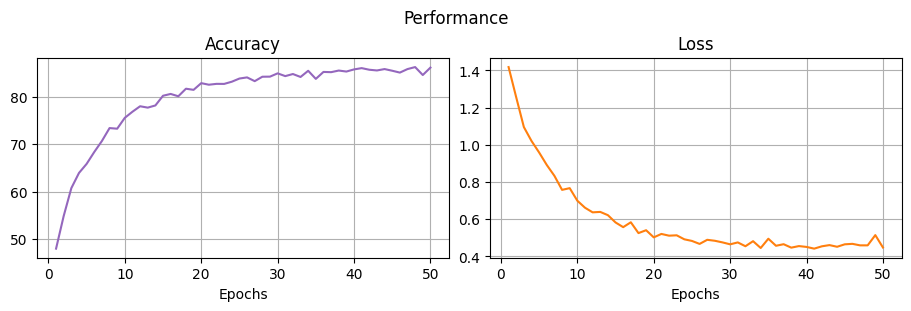

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(9, 3), layout="constrained")
fig.suptitle("Performance")

epochs = range(1, EPOCHS+1)

ax1, ax2 = axs[0], axs[1]

ax1.plot(epochs, acc, "tab:purple")
ax1.set_title("Accuracy")
ax1.set_xlabel("Epochs")
ax1.grid(True)

ax2.plot(epochs, loss, "tab:orange")
ax2.set_title("Loss")
ax2.set_xlabel("Epochs")
ax2.grid(True)

plt.savefig(f"performance_{int(time.time())}")

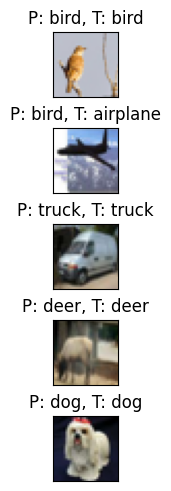

In [11]:
def predict(model):
  model.eval()
  fig, axs = plt.subplots(5, 1, layout="constrained")

  for i in range(5):
    X, label = testD[np.random.randint(len(testD))] # tensor image, label
    
    unnorm = Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0])
    img = unnorm(X)
    axs[i].imshow(img.permute(1, 2, 0))

    X = X.unsqueeze(0).to(DEVICE)
    
    with torch.no_grad():
      pred = model(X).argmax(dim=1).item()
    axs[i].set_title(f"P: {model.labels[pred]}, T: {model.labels[label]}") 
    axs[i].yaxis.set_visible(False)
    axs[i].xaxis.set_visible(False)
  
  plt.show()
  

predict(model)
